In [1]:
import numpy as np

In [2]:
A = np.zeros((20, 20))

In [3]:
np.random.seed(42)

In [4]:
A_centers=[np.random.choice(20, 2) for i in range(3)]

In [5]:
for y in range(20):
  for x in range(20):
    A[y,x] = np.sum([np.exp(-np.linalg.norm([y_1-y, x_1-x])**2/9) for [y_1,x_1] in A_centers])

In [6]:
import matplotlib.pyplot as plt

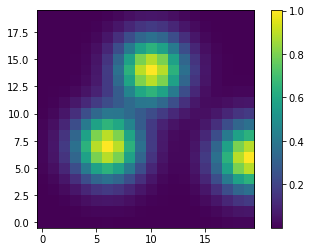

In [7]:
plt.imshow(A, origin='lower')
plt.colorbar()

In [8]:
MAP_DIM=20

In [9]:
def gen_latent_2d(num_centers=3, sigma=9, seed=42):
  rs = np.random.RandomState(seed=seed)
  A = np.zeros((MAP_DIM, MAP_DIM))
  A_centers=[rs.choice(20, 2) for i in range(num_centers)]
  for y in range(MAP_DIM):
    for x in range(MAP_DIM):
      A[y,x] = np.sum([np.exp(-np.linalg.norm([y_1-y, x_1-x])**2/sigma) for [y_1,x_1] in A_centers])
  return A

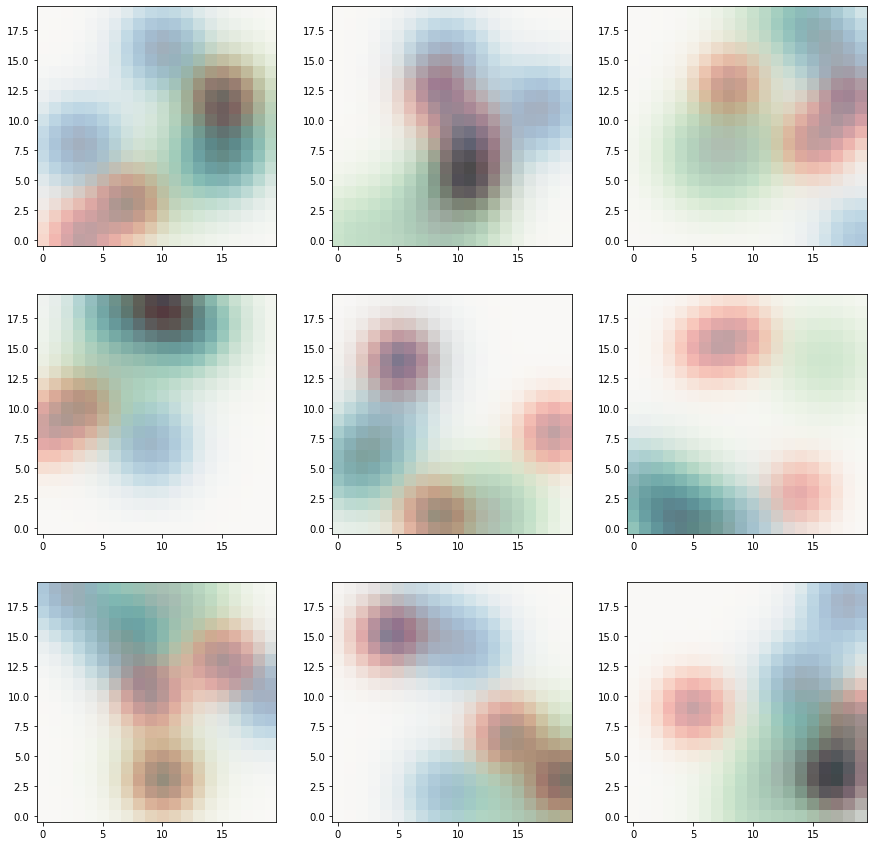

In [10]:
f, axarr = plt.subplots(3,3, figsize=(15,15)) 

for x in range(9):
  axarr[np.unravel_index(x, (3,3))].imshow(gen_latent_2d(sigma=9, seed=x), cmap=plt.cm.Reds, origin='lower')
  axarr[np.unravel_index(x, (3,3))].imshow(gen_latent_2d(sigma=16, seed=100+x), alpha=0.5, cmap=plt.cm.Blues, origin='lower')
  axarr[np.unravel_index(x, (3,3))].imshow(gen_latent_2d(sigma=25, seed=200+x), alpha=0.3, cmap=plt.cm.Greens, origin='lower')

plt.show()

In [11]:
A,B,C = gen_latent_2d(sigma=9, seed=0), gen_latent_2d(sigma=16, seed=100), gen_latent_2d(sigma=25, seed=200)

In [12]:
np.unravel_index(np.random.choice(a=MAP_DIM**2,p=(A.flatten() + B.flatten() + C.flatten())/np.sum(A.flatten() + B.flatten() + C.flatten())), (MAP_DIM, MAP_DIM))

(8, 8)

In [13]:
C_probs=(A.flatten() + B.flatten() + C.flatten())/np.sum(A.flatten() + B.flatten() + C.flatten())

In [14]:
C_rawpreds=np.random.choice(a=MAP_DIM**2, size=20, p=C_probs, replace=False)
C_preds=[np.unravel_index(C_rawpreds, (MAP_DIM, MAP_DIM)) for _ in range(20)]

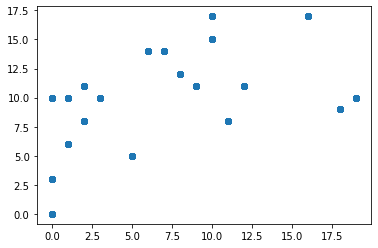

In [15]:
plt.scatter(*zip(*C_preds))

# Transportation over multiple projections

In [16]:
from ortools.sat.python import cp_model
from functools import reduce

In [20]:
# Number of scenarios to run
NUM_S = 10
# Number of predicted crimes in each scenario
NUM_Z = 10
# Number of resources to deploy
NUM_K = 20

In [66]:
def mincost_flow_model(z_s, q_limit=2):
  model = cp_model.CpModel()
  # Global sources
  q = [model.NewIntVar(0, NUM_K, f'q_{i}') for i in range(MAP_DIM**2)]
  # Total resource deployed constraint
  model.Add(reduce(lambda x,y:x+y, q) == NUM_K)
  # Transferred unit from i police unit to j crime scene in scenario s
  x_ijs = [[[model.NewIntVar(0, 1, f'x_{i}_{j}_{s}') for s in range(NUM_S)] for j in range(MAP_DIM**2)] for i in range(MAP_DIM**2)]
  # Local sources constraint
  for s in range(NUM_S):
    # Total outbound call from i can be q[i] at max.
    for i in range(MAP_DIM**2):
      model.Add(reduce(lambda x,y: x+y, [x_ijs[i][j][s] for j in range(MAP_DIM**2)]) <= q[i])
  # Sink constraint per scenario
  for s in range(NUM_S):
    z = z_s[s]
    for j in z:
      model.Add(reduce(lambda x,y:x+y, [x_ijs[i][j][s] for i in range(MAP_DIM**2)]) >= 1)
  # Set objective to minimize cost of flow in all given scenarios.
  goals = 0
  for i in range(MAP_DIM**2):
    for j in range(MAP_DIM**2):
      a = np.unravel_index(i, (MAP_DIM, MAP_DIM))
      b = np.unravel_index(j, (MAP_DIM, MAP_DIM))
      d = abs(a[0]-b[0]) + abs(a[1] - b[1])
      for s in range(NUM_S):
        x = x_ijs[i][j][s]
        goals += (x*d)
  # Hard limit on unit deployment
  for q_i in q:
    model.Add(q_i <= q_limit)
  model.Minimize(goals)
  return model, q, x_ijs

In [67]:
# Generate scenarios
np.random.seed(10042)
z_s = [np.random.choice(a=MAP_DIM**2, size=NUM_Z, p=C_probs, replace=False) for _ in range(NUM_S)]

In [68]:
def run_model(z_s, q_limit=2, time_limit=120.0):
  print("Creating a model")
  model, q, x_ijs = mincost_flow_model(z_s, q_limit=q_limit)
  solver = cp_model.CpSolver()
  solver.parameters.max_time_in_seconds = time_limit
  print("Running the solver")
  status = solver.Solve(model)
  print(status)
  zx_c={i:solver.Value(q[i]) for i in range(MAP_DIM**2) if solver.Value(q[i]) > 0}
  # Assigned positions
  zx = list(zx_c.keys())
  # Assigned flows
  ijs = [(i,j,s) for i in range(MAP_DIM**2) for j in range(MAP_DIM**2) for s in range(NUM_S) if solver.Value(x_ijs[i][j][s])>0]  
  return zx_c, zx, ijs

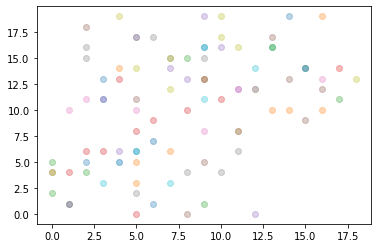

In [69]:
# plt.scatter(*np.unravel_index(zx, (MAP_DIM, MAP_DIM)), color='red', alpha=0.5)
for z in z_s:
    plt.scatter(*np.unravel_index(z, (MAP_DIM, MAP_DIM)), alpha=0.3)
plt.show()

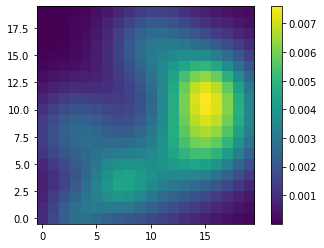

In [25]:
plt.imshow(np.reshape(C_probs, (MAP_DIM, MAP_DIM)), origin='lower')
plt.colorbar()

# Population Assignments

In [37]:
P1 = 0.2 + 0.2 * A + 0.05 * B + 0.01 * C
P2 = 0.2 - 0.001 * A - 0.05 * B + 0.01 * C

In [38]:
N_POP=100000
N_POP2=100000

In [39]:
def assign_population(prop, n_pop, seed=42):
  np.random.seed(seed)
  pa = np.zeros((MAP_DIM, MAP_DIM))
  for x in np.random.choice(a=MAP_DIM**2, size=n_pop, p=prop.flatten()/sum(prop.flatten()), replace=True):
    pa[np.unravel_index(x, (MAP_DIM, MAP_DIM))]+=1
  return pa

In [40]:
P1A=assign_population(P1, N_POP)
P2A=assign_population(P2, N_POP2)

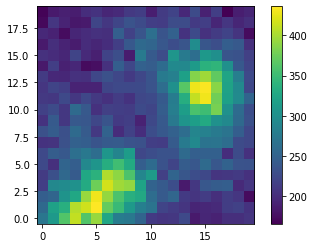

In [41]:
plt.imshow(P1A, origin='lower')
plt.colorbar()

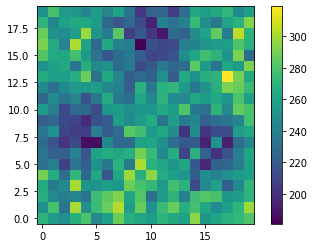

In [42]:
plt.imshow(P2A, origin='lower')
plt.colorbar()

## Assign population to simulated incidents

In [43]:
def local_pick(p1a, p2a, loc):
  n=p1a[loc] + p2a[loc]
  return np.random.choice(a=2, p=[p1a[loc]/n, p2a[loc]/n])


def assign_population(p1a, p2a, z_s, seed=42):
  np.random.seed(seed)
  unraveled = [list(zip(x,y)) for x,y in [np.unravel_index(z, (MAP_DIM, MAP_DIM)) for z in z_s]]
  return np.array([[local_pick(p1a, p2a, loc) for loc in zu] for zu in unraveled])

In [44]:
# [list(zip(x,y)) for x,y in [np.unravel_index(z, (MAP_DIM, MAP_DIM)) for z in z_s]]

In [45]:
pa_s=assign_population(P1A, P2A, z_s)

In [46]:
pa_s

array([[0, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 0]])

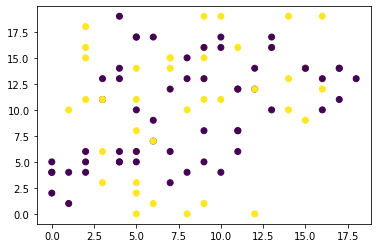

In [48]:
for i, z in enumerate(z_s):
  plt.scatter(*np.unravel_index(z, (MAP_DIM, MAP_DIM)), c=pa_s[i])
plt.show()

In [55]:
def onenorm(i, j):
  a = np.unravel_index(i, (MAP_DIM, MAP_DIM))
  b = np.unravel_index(j, (MAP_DIM, MAP_DIM))
  d = abs(a[0]-b[0]) + abs(a[1] - b[1])
  return d

In [57]:
# Divide incidents between p1 and p2.

p1_zs = [set() for _ in range(NUM_S)]
p2_zs = [set() for _ in range(NUM_S)]

for s in range(NUM_S):
  for i in range(NUM_Z):
    if pa_s[s][i] == 0:
      p1_zs[s].add(z_s[s][i])
    else:
      p2_zs[s].add(z_s[s][i])

In [58]:
def print_cost(ijs):
  # Calculate cost distribution
  all_cost = [onenorm(i,j) for (i, j, _) in ijs]
  print(np.mean(all_cost), np.var(all_cost))
  p1_cost=[onenorm(i,j) for (i, j, s) in ijs if j in p1_zs[s]]
  print(np.mean(p1_cost), np.var(p1_cost))
  p2_cost=[onenorm(i,j) for (i, j, s) in ijs if j in p2_zs[s]]
  print(np.mean(p2_cost), np.var(p2_cost))

# Quick run with limit=2

In [52]:
zx_c2, zx2, ijs2 = run_model(z_s, q_limit=2)

Creating a model
Running the solver
2


In [59]:
print_cost(ijs2)

12.02 33.619600000000005
11.857142857142858 26.94387755102041
12.227272727272727 42.03925619834711


# Compare with limit=3

In [61]:
zx_c3, zx3, ijs3 = run_model(z_s, q_limit=3)

Creating a model
Running the solver
2


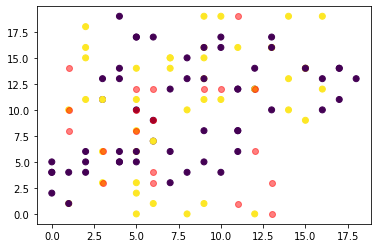

In [62]:
for i, z in enumerate(z_s):
  plt.scatter(*np.unravel_index(z, (MAP_DIM, MAP_DIM)), c=pa_s[i])
plt.scatter(*np.unravel_index(zx3, (MAP_DIM, MAP_DIM)), color='red', alpha=0.5)
plt.show()

In [63]:
print_cost(ijs3)

10.81 31.0139
10.946428571428571 35.300701530612244
10.636363636363637 25.50413223140496


# Limit=4

In [64]:
zx_c4, zx4, ijs4 = run_model(z_s, q_limit=4)

Creating a model
Running the solver
2


In [65]:
print_cost(ijs4)

10.44 38.4064
9.625 38.66294642857143
11.477272727272727 36.15857438016529


# Limit=1

In [70]:
zx_c1, zx1, ijs1 = run_model(z_s, q_limit=1)

Creating a model
Running the solver
2


In [71]:
print_cost(ijs1)

10.93 35.2651
11.875 34.78794642857143
9.727272727272727 33.289256198347104


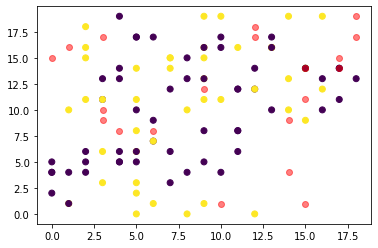

In [72]:
for i, z in enumerate(z_s):
  plt.scatter(*np.unravel_index(z, (MAP_DIM, MAP_DIM)), c=pa_s[i])
plt.scatter(*np.unravel_index(zx1, (MAP_DIM, MAP_DIM)), color='red', alpha=0.5)
plt.show()

# Save the model

In [73]:
import pickle

In [74]:
# Latent factors
pickle.dump([A, B, C], open('latent.p', 'wb'))

In [75]:
# Crime probability
pickle.dump(C_probs, open('C_probs.p', 'wb'))

In [76]:
# Population Assignments
pickle.dump([P1A, P2A], open('pop.p', 'wb'))

In [77]:
# Crime simulation
pickle.dump(z_s, open('z_s.p', 'wb'))

In [78]:
pickle.dump([zx_c1, zx1, ijs1], open('model_ql1.p', 'wb'))

In [79]:
pickle.dump([zx_c2, zx2, ijs2], open('model_ql1.p', 'wb'))

In [80]:
pickle.dump([zx_c3, zx3, ijs3], open('model_ql3.p', 'wb'))

In [81]:
pickle.dump([zx_c4, zx4, ijs4], open('model_ql4.p', 'wb'))

# Check police presence disparity

In [82]:
import typing

In [83]:
def within_boundary(x:int,y:int) -> bool:
  return x >= 0 and y >= 0 and x < MAP_DIM and y < MAP_DIM

In [84]:
def nearby_cells(origin:int, radius:int) -> [int]:
  (origin_x, origin_y) = np.unravel_index(origin, (MAP_DIM, MAP_DIM))
  s : typing.Set[(int, int)] = set()
  for x in range(0, radius+1):
    for y in range(0, radius+1-x):
      if within_boundary(origin_x+x, origin_y+y):
        s.add((origin_x+x, origin_y+y))
      if within_boundary(origin_x-x, origin_y+y):
        s.add((origin_x-x, origin_y+y))
      if within_boundary(origin_x+x, origin_y-y):
        s.add((origin_x+x, origin_y-y))
      if within_boundary(origin_x-x, origin_y-y):
        s.add((origin_x-x, origin_y-y))
  return np.ravel_multi_index(list(zip(*s)), (MAP_DIM, MAP_DIM))

In [85]:
# nearby_cells(15, 3)

In [86]:
# np.ravel_multi_index(list(zip(*[(2, 14), (1, 15), (2, 16)])), (MAP_DIM, MAP_DIM))

In [87]:
def police_count(loc, radius, zx_c):
  return sum([zx_c[l] for l in nearby_cells(loc, radius) if l in zx_c])

In [88]:
police_count(23, 3, zx_c1)

0

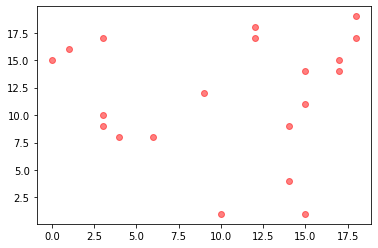

In [89]:
plt.scatter(*np.unravel_index(zx1, (MAP_DIM, MAP_DIM)), color='red', alpha=0.5)

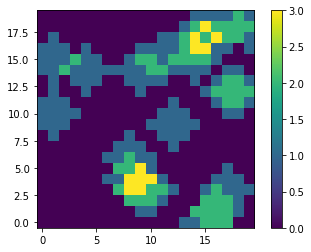

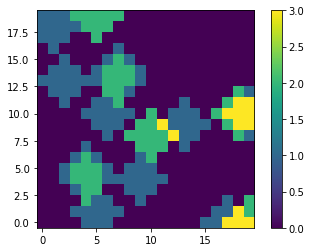

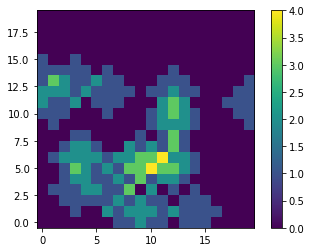

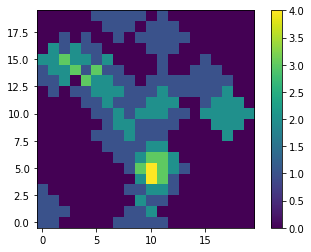

In [91]:
for zxc in [zx_c1, zx_c2, zx_c3, zx_c4]:
  plt.imshow(np.reshape([police_count(l, 2, zxc) for l in range(0,400)], (MAP_DIM, MAP_DIM)), origin='lower')
  plt.colorbar()
  plt.show()

In [92]:
from collections import defaultdict

In [93]:
import seaborn as sns

In [94]:
import pandas as pd

In [110]:
def calc_pol_bucket(zxc):
  max_count=0
  bucket=np.zeros(50)
  bucket2=np.zeros(50)
  for i in range(MAP_DIM*MAP_DIM):
    pcount = police_count(i, 2, zxc)
    bucket[pcount] += P1A[np.unravel_index(i, (MAP_DIM, MAP_DIM))]
    bucket2[pcount] += P2A[np.unravel_index(i, (MAP_DIM, MAP_DIM))]
    if pcount > max_count:
      max_count = pcount
  return bucket[:max_count+1], bucket2[:max_count+1]

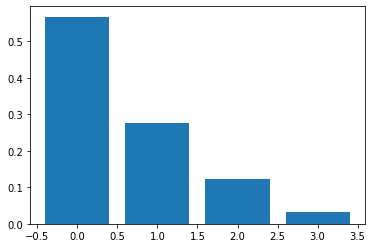

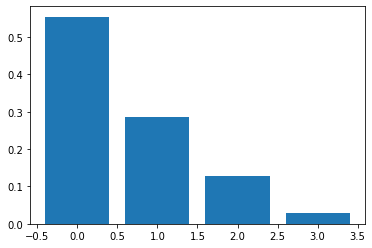

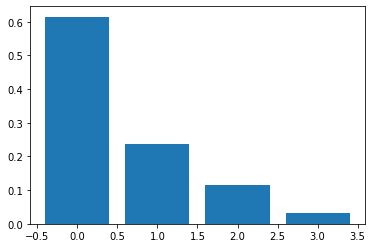

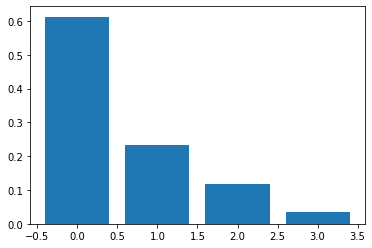

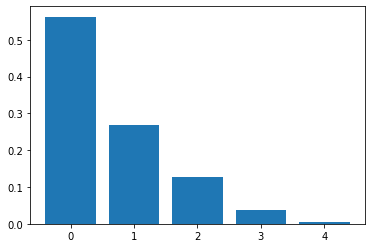

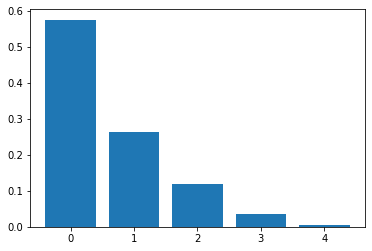

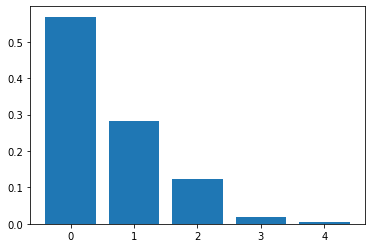

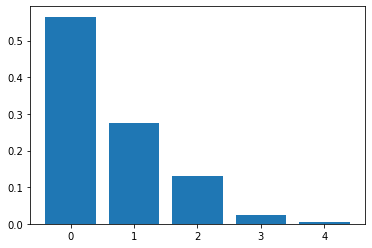

In [111]:
for zx_c in [zx_c1, zx_c2, zx_c3, zx_c4]:
  bucket, bucket2 = calc_pol_bucket(zx_c)
  plt.bar(x=range(len(bucket)), height=bucket/sum(bucket))
  plt.show()
  plt.bar(x=range(len(bucket2)), height=bucket2/sum(bucket2))
  plt.show()

In [112]:
from scipy.stats import entropy

In [113]:
for zxc in [zx_c1, zx_c2, zx_c3, zx_c4]:
  bucket, bucket2 = calc_pol_bucket(zxc)
  print(entropy(bucket/sum(bucket), bucket2/sum(bucket2)))

0.00039951620487719067
0.00023414262061327747
0.00048566833719093736
0.0007141302472004913


# Running with longer deadline

In [455]:
for x in range(4):
  print(x)
  zx_ci, zxi, ijsi = run_model(z_s, q_limit=x+1,time_limit=1800.0)
  print_cost(ijsi)
  pickle.dump([zx_ci, zxi, ijsi], open(f'model_ql{x}_1800.p', 'wb'))

0
2
10.19 28.033899999999996
10.428571428571429 30.994897959183675
9.886363636363637 24.100723140495873
1
2
11.81 35.73389999999999
10.375 32.877232142857146
13.636363636363637 33.413223140495866
2
2
11.11 32.2179
12.125 31.966517857142858
9.818181818181818 29.557851239669425
3
2
10.82 29.4076
10.571428571428571 26.9234693877551
11.136363636363637 32.3904958677686


In [765]:
# Load longer run models for further investigation
zx_ci, zxi, ijsi = zip(*[pickle.load(open(f'model_ql{x}_1800.p', 'rb')) for x in range(4)])

In [813]:
for x in range(4):
  print(x)
  print_cost(ijsi[x])

0
10.19 28.033899999999996
10.649122807017545 28.964604493690366
9.581395348837209 26.150351541373713
1
11.81 35.73389999999999
10.543859649122806 31.160357032933206
13.488372093023257 36.85451595457005
2
11.11 32.2179
12.157894736842104 32.86980609418283
9.720930232558139 27.96863169280692
3
10.82 29.4076
10.43859649122807 27.439212065250846
11.325581395348838 31.568415359653866


In [100]:
# TODO: Repeat analyses for longer-run data.